## Домашнее задание №4. Классификация статей с помощью тематических моделей
Сдача задания производится по адресу `bdt-mf-ml-nlp-2020-q4@bigdatateam.org`

В теме письма указать: "HW4:topic modeling. ФИО"

Если какие-то библиотеки недоступны, можно установить их в используемое окружение (environment), например `my_env`, используя пакетный менеджер `pip`: 

```
conda activate my_env
pip install gensim 
pip install pyLDAvis
pip install scikit-plot
```

In [2]:
!pip install gensim 
!pip install pyLDAvis
!pip install scikit-plot

     |████████████████████████████████| 1.6MB 8.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=56df11bed984561f979fa1c8d22a4a50ec07090fffa04b62410964a8eb028cd6
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


Пример настройки окружения и `requirements.txt` доступны в репозитории: https://github.com/big-data-team/nlp-course

In [3]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 8.2MB 11.2MB/s 


In [4]:
import pandas as pd
import nltk
import pymorphy2

In [11]:
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized

train = fetch_20newsgroups(subset='train',  remove=('headers', 'footers', 'quotes'))
train_data, train_labels = train['data'], train['target']

test = fetch_20newsgroups(subset='test',  remove=('headers', 'footers', 'quotes'))
test_data, test_labels = test['data'], test['target']

In [ ]:
test['data'][0]

'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

In [ ]:
train['data'][0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

### Построение тематических моделей (и использование для классификации текстов)
В данном задании мы построим несколько тематических моделей и займемся подбором подходящих гиперпараметров. Построенные тематические профили будут использоваться для дальнейшей классификации текстов.

В задании будем пользоваться датасетом `20newsgroups dataset`. Он доступен через интерфейс `sklearn` и уже загружен выше.

In [58]:
NUM_TOPICS = 20

#### 1. Построение baseline решения (10% + 10% за переиспользуемый метод для оценки качества + 5% за предобработку текстов)
Постройте базовое решение для классификации текстов.

Для начала выполните предобработку текстов:
    - удалите пунктуацию
    - приведите слова к нижнему регистру
    - удалите стоп-слова
    - лемматизация/стемминг
    - etc.

In [28]:
import re

def preprocess(papers, column):

    papers = pd.DataFrame(papers[column])
    # Remove punctuation
    papers['paper_text_processed'] = papers[0].map(lambda x: re.sub('[0-9,\.!?_()$#@{}\[\]*^<>]', '', x))
    papers['paper_text_processed'] = papers.apply(lambda x: x.paper_text_processed.replace("\n", " ").strip(), axis = 1)

    # Convert the titles to lowercase
    papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

    # lemmatization
    papers['paper_text_processed'] = papers.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x.paper_text_processed)]), axis = 1)


    return papers

In [29]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [30]:
lemmatizer = WordNetLemmatizer()

In [ ]:
#lemmatizer.lemmatize("bats")

'bat'

In [31]:
test = preprocess(test, 'data')
train = preprocess(train, 'data')

In [ ]:
test.head()

,0,paper_text_processed
0,I am a little confused on all of the models of...,i am a little confused on all of the model of ...
1,I'm not familiar at all with the format of the...,i 'm not familiar at all with the format of th...
2,"\nIn a word, yes.\n",in a word yes
3,\nThey were attacking the Iraqis to drive them...,they were attacking the iraqi to drive them ou...
4,\nI've just spent two solid months arguing tha...,i 've just spent two solid month arguing that ...


Для векторизации текстов вы можете воспользоваться BoW, TF-IDF или Bag of Embeddings аналогично первому занятию. Вы можете свободно пользоваться методами из `sklearn` или других библиотек, необходимости реализовывать их самостоятельно в этот раз нет.

*Комментарий: будьте осторожны с разбиением на train и test, не допускайте утечек данных (data leaks).*

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


# Initialise the count vectorizer with the English stop words
count_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the processed titles
count_vectorizer.fit(train['paper_text_processed'])

count_data_train = count_vectorizer.transform(train['paper_text_processed'])
count_data_test = count_vectorizer.transform(test['paper_text_processed'])


В качестве модели можно использовать логистическую регрессию, наивный байесовский классификатор или что-то еще. Основное ограничение модель должна быть простой (как в реализации, так и по своей структуре). Это первая попытка построить baseline.

In [33]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(count_data_train, train_labels)

И, наконец, оцените качество классификации с помощью построенной модели. Сравните качество классификации на обучающей и тестовой выборке.

Также постройте ROC-кривую и оцените площадь под ROC-кривой. Т.к. сейчас мы работаем с задачей классификации на 20 классов, реализация из `sklearn` не слишком удобна. Для удобства можно воспользоваться `scikitplot`. Команда для его установки доступна в самом начале ноутбука. Пример использования доступен ниже:

```
scikitplot.metrics.plot_roc(test_labels, predicted_proba)
```

In [41]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [42]:
import scikitplot

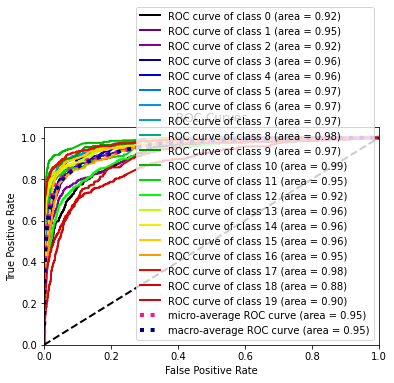

In [14]:
scikitplot.metrics.plot_roc(test_labels, clf.predict_proba(count_data_test))

In [ ]:
evaluate_results(test_labels, clf.predict(count_data_test))

accuracy : 0.6818906001062135
f1_macro : 0.6692561119308169
f1_micro : 0.6818906001062135


In [ ]:
evaluate_results(train_labels, clf.predict(count_data_train))

accuracy : 0.9082552589711861
f1_macro : 0.9080345028810892
f1_micro : 0.9082552589711861


**Рекомендация:** полезно будет оформить отдельные функции/классы для оценки качества классификации. Это упростит дальнейшую работу и сделает код более читаемым. 

Например, на вход можно подавать векторы вероятностей и истинные метки классов:

```
def evaluate_results(real_labels, predicted_probas, num_classes=None, caption='My model resulst'):
    return 'It is awesome!'
```

In [34]:
def evaluate_results(real_labels, predicted_classes, num_classes=None, caption='My model resulst'):
    print('accuracy :', accuracy_score(real_labels, predicted_classes))
    print('f1_macro :', f1_score(real_labels, predicted_classes, average='macro'))
    print('f1_micro :', f1_score(real_labels, predicted_classes, average='micro'))

#### 2. Построение тематической модели
Теперь обратимся к тематическому моделированию. Тематический профиль статьи будем использовать в качестве нового признакового описания.

Воспользуйтесь хотя бы тремя различными методами:

* PLSA
* LDA
* BERTopic
* Опционально: BigARTM или TopicNet

Порядок экспериментов опционален. Поэкспериментируйте с добавлением биграмм и подбором параметров.

Попробуйте объединить представление текста из baseline решения (BOW, TF-IDF, etc.) и тематические вектора в одно признаковое описание. 

##### Experiment 1 (20%)
*Опциональные вводные слова*

In [53]:
from gensim import corpora, models

In [80]:
test['tokenized_text'] = test.apply(lambda x : nltk.word_tokenize(x['paper_text_processed']),axis = 1)
train['tokenized_text'] = train.apply(lambda x : nltk.word_tokenize(x['paper_text_processed']),axis = 1)

In [86]:
def dic_corpus(texts, column):
    dictionary = corpora.Dictionary(texts[column])

    corpus = [dictionary.doc2bow(text) for text in texts[column]]
    
    return dictionary, corpus

In [87]:
dictionary_test, corpus_test = dic_corpus(test, 'tokenized_text')
dictionary_train, corpus_train = dic_corpus(train, 'tokenized_text')

In [59]:
from gensim.models.ldamodel import LdaModel
lda_small = LdaModel(corpus_train, num_topics=NUM_TOPICS)

In [21]:
! pip install wordcloud
! pip install pyLDAvis

In [22]:
import pyLDAvis
import wordcloud
import os

In [26]:
from pyLDAvis import gensim as gensim_lda

pyLDAvis.enable_notebook()

gensim_lda_vis_fp = os.path.join('./gensim_small' + str(NUM_TOPICS))
gensim_lda_vis = gensim_lda.prepare(lda_small, corpus_train, dictionary_train)

pyLDAvis.save_html(gensim_lda_vis, gensim_lda_vis_fp +'.html')

gensim_lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.216438 -0.057029       1        1  37.889060
7     -0.197925 -0.053006       2        1  15.630705
9     -0.117976 -0.064970       3        1   7.163425
15    -0.151062 -0.009101       4        1   5.482733
10    -0.128021 -0.053586       5        1   5.180776
16    -0.126854 -0.042989       6        1   4.872900
14    -0.150955 -0.024401       7        1   4.814011
3     -0.113348 -0.021668       8        1   4.505115
2      0.285323 -0.166369       9        1   3.564107
11     0.364227 -0.168888      10        1   2.594612
17    -0.109090  0.010996      11        1   2.091233
8      0.000769 -0.041093      12        1   1.971472
1      0.000220  0.075919      13        1   1.039149
5     -0.052671  0.076778      14        1   0.601857
6     -0.017264  0.077862      15        1   0.566614
19     0.297895  0.105034      16        1   0.558339
18     0.112186  0.192805      17        1   0.477980
0     -0.026606  0.089508      18        1   0.374228
13     0.228320  0.053833      19        1   0.322539
4      0.119272  0.020367      20        1   0.299144, topic_info=    Term           Freq          Total Category  logprob  loglift
128   --   52103.000000   52103.000000  Default  30.0000  30.0000
55   the  102347.000000  102347.000000  Default  29.0000  29.0000
121   ''   25969.000000   25969.000000  Default  28.0000  28.0000
129    :   32362.000000   32362.000000  Default  27.0000  27.0000
375    %   13261.000000   13261.000000  Default  26.0000  26.0000
..   ...            ...            ...      ...      ...      ...
29    it      16.559499   24941.439495  Topic20  -6.0247  -1.5053
330  not      14.503398   13144.721166  Topic20  -6.1573  -0.9974
125   's      12.937332   11409.294035  Topic20  -6.2715  -0.9701
92   n't      12.069073   10231.472921  Topic20  -6.3410  -0.9306
39    on      12.163027   13677.452746  Topic20  -6.3332  -1.2131

[1688 rows x 6 columns], token_table=      Topic      Freq Term
term                      
375       1  0.007917    %
375       2  0.002865    %
375       3  0.000829    %
375       4  0.002187    %
375       5  0.008822    %
...     ...       ...  ...
1354     13  0.001806    |
1354     14  0.075856    |
1354     15  0.002258    |
1354     16  0.000452    |
1354     20  0.000452    |

[6436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 8, 10, 16, 11, 17, 15, 4, 3, 12, 18, 9, 2, 6, 7, 20, 19, 1, 14, 5])

Используйте тематические вектора в качества признаков для логистической регрессии.

In [27]:
NUM_TOPICS = 20

In [26]:
from scipy.sparse import coo_matrix, vstack, csr_matrix, hstack

In [ ]:
NUM_TOPICS = 300
lda_small = LdaModel(corpus_train, num_topics=NUM_TOPICS)

In [62]:
def sparce_texts(texts, dictr, lda):
  row = []
  col = []
  data = []
  for index, text in enumerate(texts['tokenized_text'][:]):
    doc_bow = dictr.doc2bow(text)
    for i in lda.get_document_topics(doc_bow):
      row.append(index)
      col.append(i[0])
      data.append(i[1])
  return row, col, data

  

In [39]:
row, col, data = sparce_texts(train, dictionary_train, lda_small)
csr_matrix_train = csr_matrix((data, (row, col)), shape=(len(train['tokenized_text']), len(dictionary_train)))

In [41]:
row, col, data = sparce_texts(test, dictionary_train, lda_small)
csr_matrix_test = csr_matrix((data, (row, col)), shape=(len(test['tokenized_text']), len(dictionary_train)))

In [43]:
train_f = hstack([count_data_train, csr_matrix_train])
test_f = hstack([count_data_test, csr_matrix_test])

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(train_f, train_labels)

pred_labels = lr.predict(train_f)

In [45]:
pred_labels = lr.predict(test_f)

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_score(test_labels, pred_labels)

0.6436537440254912

In [47]:
precision_score(test_labels, pred_labels, average='macro')

0.6417705163696713

In [48]:
recall_score(test_labels, pred_labels, average='macro')

0.6306589685529194

In [49]:
evaluate_results(test_labels, pred_labels)

accuracy : 0.6436537440254912
f1_macro : 0.6297095518297846
f1_micro : 0.6436537440254912


##### Experiment 2 (20%)
*Опциональные вводные слова*

In [52]:
from gensim.models.lsimodel import LsiModel

In [60]:
NUM_TOPICS = 300
lsi_model = LsiModel(
   corpus=corpus_train, id2word=dictionary_train, num_topics=NUM_TOPICS,chunksize=100
)

In [76]:
word_idx = {i: dictionary_train[i] for i,word in enumerate(dictionary_train)}

In [ ]:
corpus_train

In [127]:
def sparce_texts_lsi(texts, lda):
  index = 0
  row = []
  col = []
  data = []
  for text in texts:
    doc_bow = lda[text]
    for i in doc_bow:
      row.append(index)
      col.append(i[0])
      data.append(i[1])
    index+=1
  return row, col, data

In [145]:
row, col, data = sparce_texts_lsi(corpus_train, lsi_model)
csr_matrix_train = csr_matrix((data, (row, col)), shape=(len(corpus_train), lsi_model.get_topics().shape[0]))

In [146]:
row, col, data = sparce_texts_lsi(corpus_test, lsi_model)
csr_matrix_test = csr_matrix((data, (row, col)), shape=(len(corpus_test), lsi_model.get_topics().shape[0]))

In [148]:
train_f = hstack([count_data_train, csr_matrix_train])
test_f = hstack([count_data_test, csr_matrix_test])

In [149]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(train_f, train_labels)

pred_labels = lr.predict(train_f)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [150]:
pred_labels = lr.predict(test_f)

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_score(test_labels, pred_labels)

0.5674455655868296

In [152]:
precision_score(test_labels, pred_labels, average='macro')

0.6235430601396202

In [153]:
recall_score(test_labels, pred_labels, average='macro')

0.5499946726256778

In [154]:
evaluate_results(test_labels, pred_labels)

accuracy : 0.5674455655868296
f1_macro : 0.5467802567192962
f1_micro : 0.5674455655868296


##### Experiment 3 (20%)
*Опциональные вводные слова*

In [7]:
! pip install bertopic

     |████████████████████████████████| 4.7MB 10.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 307kB 51.6MB/s 
     |████████████████████████████████| 71kB 12.2MB/s 
     |████████████████████████████████| 1.8MB 53.3MB/s 
     |████████████████████████████████| 1.2MB 54.1MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 
     |████████████████████████████████| 2.9MB 52.6MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301777 sha256=168f693c324f961482e88d24c90cc776076266ab82ae993e833a351bedc101aa
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=d68cb5eb3235b620ea301447f1c5c75f93c539af2ecc531db2c1c2d0f1a1a9aa

In [9]:
from bertopic import BERTopic

In [22]:
model = BERTopic(n_gram_range=(1, 2), stop_words="english")
model.fit(train['data'])
topics, probabilities = model.transform(test['data'])

In [24]:
topics, probabilities_train = model.transform(train['data'])

In [35]:
train_f = hstack([count_data_train, csr_matrix(probabilities_train)])
test_f = hstack([count_data_test, csr_matrix(probabilities)])

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr.fit(train_f, train_labels)

pred_labels = lr.predict(test_f)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_score(test_labels, pred_labels)

0.6298459904407859

In [38]:
precision_score(test_labels, pred_labels, average='macro')

0.6391485815471943

In [39]:
recall_score(test_labels, pred_labels, average='macro')

0.618647455678546

In [43]:
evaluate_results(test_labels, pred_labels)

accuracy : 0.6298459904407859
f1_macro : 0.6209098523065609
f1_micro : 0.6298459904407859


#### Выводы и отчет о проделанных экспериментах (15%)
Какие выводы можно сделать на основе полученных результатов? Удалось ли повысить качество классификации с помощью тематических моделей относительно baseline решения?

**Выводы:** Без ждостаточного тюнинга и повсеместного использования биграмов не поулчилось преодолеть бейзлайн. Топики больше вносили шума, хотя я и не исключаю ошибку в имплементации.  

Также, пожалуйста, напишите небольшой отчет о проделанной работе (2-3 абзаца текста достаточно, лучше выделить основные результаты и шаги, которые были предприняты).

**Отчет:** Были использованы три предложенные модели. Биграммы были использованы только в BERTopic, потому что глаз за них зацепился при чтении документации. В остальных моделях я начал с 300 топиков, держа в голове совет из телеграма. 
Если честно, я не пытался особо экспериментировать с их количеством, потому что уже дедлайн поджимал, как и не пытался подтюнить немгого регрессию, или использовать вместо нее другой алгоритм. 
Если это добавить в туду: то, конечно, нужно было бы подобрать количество топиков и добавить в текст биграммы для lda/lsi.


Пожалуйста, оставьте обратную связь о задании [по ссылке](http://rebrand.ly/mfnlp2020q4_feedback_hw04). Она анонимна ;)
______

#### Bonus area: BigARTM & TopicNet (15+%)
Попробуйте воспользоваться BigARTM (или TopicNet) для построения тематических профилей данных статей. Сравните результаты классификации на основе данных профилей с остальными подходами.

In [ ]:
# your bonus code here

#### Bonus area: RNNs are coming (15+%)
Дополнительно, попробуйте адаптировать рекуррентные модели для классификации данных текстов. Происходит ли переобучение?
Попробуйте воспользоваться `Dropout` в рекуррентной нейронной сети.

*Замечание: рекуррентные нейронные сети требуют повышенного внимания при внедрении `Dropout`. Вставлять его непосредственно между рекуррентными блоками может быть не лушей идеей.* 

In [ ]:
# your bonus code here

На всякий случай, дублируем [ссылку на форму обратной связи](http://rebrand.ly/mfnlp2020q4_feedback_hw04). Она (при желании) анонимна ;)